## Introduction
The idea behind this type of prediction which is more like fundamental evaluation actually since i'm not predicting future USD/RUB price directly is that DNN after analysed the most influential historical data and grasped fundamental dependencies is capable enough to accurately detect anomalies in USD/RUB  pricing. And based on Regression toward the mean phenomenon we can bet against those anomalies.  Based on my knowledge and understanding of the markets the most significant assets to influence USD/RUB price are: government bonds, repo rates, oil, and stock indexes. Let's examine those dependencies first.

In [1]:
import numpy as np
import pandas as pd
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import datetime as dt
import pandas_datareader.data as web
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline

start = dt.datetime.now()-dt.timedelta(days=15)
end = dt.datetime.now()

## Read in an old dataset from csv 

In [2]:
df_old=pd.read_csv('ML_DF_Regression.csv', nrows= 601, index_col=0)
df_old.head(1)

,Brent,EUR_USD,Emerging_Markets,MOEXBC,RGBITR_YIELD,Russia_ETF,Treas_4M,USD_RUB,USD_Repo,VOL_USD,percent_change
Date,,,,,,,,,,,
2019-08-28,60.5,1.10745,39.439999,18106.96,7.14,21.870001,1.94,66.8,2.08,1.834422e+11,0.613774


## Acquiring new data from Moscow Exchange and Yahoo finance  

In [3]:
Brent = web.get_data_moex('BRU9', start, end)
Brent.drop(Brent.columns.difference(['CLOSE']), 1, inplace=True)
Brent.index.name= 'Date'
Brent.rename(columns={'CLOSE':'Brent'}, inplace=True)

EUR_USD = web.get_data_moex('EURUSD000TOM', start, end)
EUR_USD=EUR_USD.loc[EUR_USD.BOARDID=='CETS']
EUR_USD.drop(EUR_USD.columns.difference(['CLOSE']), 1, inplace=True)
EUR_USD.index.name= 'Date'
EUR_USD.rename(columns={'CLOSE':'EUR_USD'}, inplace=True)

USD_RUB_New = web.get_data_moex('USD000UTSTOM', start, end)
USD_RUB_New=USD_RUB_New.loc[USD_RUB_New.BOARDID=='CETS']
USD_RUB_New.index.name= 'Date'
USD_RUB_New.drop(USD_RUB_New.columns.difference(['CLOSE','VOLRUR','OPEN']), 1, inplace=True)
USD_RUB_New.rename(columns={'CLOSE':'USD_RUB','VOLRUR':'VOL_USD', 'OPEN':'USD_OPEN'}, inplace=True)
USD_RUB_New['percent_change']=(USD_RUB_New.USD_RUB-USD_RUB_New.USD_OPEN)/USD_RUB_New.USD_OPEN*100

RGBITR_New= web.get_data_moex('RGBITR', start, end)
RGBITR_New.drop(RGBITR_New.columns.difference(['YIELD']), 1, inplace=True)
RGBITR_New.index.name= 'Date'
RGBITR_New.index=pd.to_datetime(RGBITR_New.index)
RGBITR_New.rename(columns={'YIELD':'RGBITR_YIELD'}, inplace=True)

USD_Repo = web.get_data_moex('MOEXREPOUSD', start, end)
USD_Repo.drop(USD_Repo.columns.difference(['CLOSE']), 1, inplace=True)
USD_Repo.rename(columns={'CLOSE':'USD_Repo'}, inplace=True)
USD_Repo.index.name= 'Date'
USD_Repo.index=pd.to_datetime(USD_Repo.index)

MOEXBC_New= web.get_data_moex('MOEXBC', start, end)
MOEXBC_New.drop(MOEXBC_New.columns.difference(['CLOSE']), 1, inplace=True)
MOEXBC_New.index.name= 'Date'
MOEXBC_New.index=pd.to_datetime(MOEXBC_New.index)
MOEXBC_New.rename(columns={'CLOSE':'MOEXBC'}, inplace=True)

tickers = ['RSX','^IRX','EEM']
ETFs = pd.DataFrame()    

for ticker in tickers:
        ETF = web.get_data_yahoo(ticker, start, end)
        ETF.rename(columns={'Adj Close': ticker}, inplace=True)
        ETF.drop(['Open', 'High', 'Low', 'Close', 'Volume'], 1, inplace=True)
        if ETFs.empty:
            ETFs = ETF
        else:
            ETFs = ETFs.join(ETF, how='outer')
ETFs.rename(columns={'RSX': 'Russia_ETF', '^IRX':'Treas_4M','EEM': 'Emerging_Markets'}, inplace=True)

my_data=[Brent.Brent, EUR_USD.EUR_USD, ETFs.Emerging_Markets, MOEXBC_New.MOEXBC, RGBITR_New.RGBITR_YIELD, ETFs.Russia_ETF, ETFs.Treas_4M, USD_RUB_New.USD_RUB, USD_Repo.USD_Repo,
USD_RUB_New.VOL_USD, USD_RUB_New.percent_change]
my_data=pd.concat(my_data,axis=1)
my_data.index=pd.to_datetime(my_data.index)
my_data.dropna(inplace=True)
my_data.tail(2)

,Brent,EUR_USD,Emerging_Markets,MOEXBC,RGBITR_YIELD,Russia_ETF,Treas_4M,USD_RUB,USD_Repo,VOL_USD,percent_change
Date,,,,,,,,,,,
2019-08-27,58.7,1.10898,39.330002,17973.86,7.17,21.719999,1.943,66.4425,2.09,1.696794e+11,0.464958
2019-08-28,60.5,1.10745,39.439999,18106.96,7.14,21.870001,1.940,66.8000,2.08,1.834422e+11,0.613774


## Joining old and new datasets and saving back to csv

In [4]:
new_df = df_old.append(my_data)
new_df.index=pd.to_datetime(new_df.index)
new_df.sort_index(ascending=False,inplace=True)
new_df.drop_duplicates(inplace=True)
new_df.dropna(inplace=True)
new_df.to_csv('ML_DF_Regression.csv')
new_df.head(4)

,Brent,EUR_USD,Emerging_Markets,MOEXBC,RGBITR_YIELD,Russia_ETF,Treas_4M,USD_RUB,USD_Repo,VOL_USD,percent_change
Date,,,,,,,,,,,
2019-08-28,60.50,1.10745,39.439999,18106.96,7.14,21.870001,1.940,66.8000,2.08,1.834422e+11,0.613774
2019-08-27,58.70,1.10898,39.330002,17973.86,7.17,21.719999,1.943,66.4425,2.09,1.696794e+11,0.464958
2019-08-26,59.16,1.10978,39.259998,18015.13,7.16,21.860001,1.933,66.0700,2.10,1.282148e+11,0.151584
2019-08-23,58.78,1.11348,39.049999,18058.85,7.15,21.740000,1.910,65.9850,2.11,2.163388e+11,0.556233


## Read in the first 600 rows, which are in our case the latest 600 trading days or almost two and a half years.

In [5]:
main_df=pd.read_csv('ML_DF_Regression.csv', nrows= 600)
main_df.reset_index(drop=True,inplace=True)
main_df.head(1)

,Date,Brent,EUR_USD,Emerging_Markets,MOEXBC,RGBITR_YIELD,Russia_ETF,Treas_4M,USD_RUB,USD_Repo,VOL_USD,percent_change
0,2019-08-28,60.5,1.10745,39.439999,18106.96,7.14,21.870001,1.94,66.8,2.08,1.834422e+11,0.613774


In [6]:
main_df['USD_RUB'].describe()

count    600.000000
mean      61.876842
std        3.876225
min       55.705000
25%       57.900000
50%       62.520000
75%       65.491875
max       70.565000
Name: USD_RUB, dtype: float64

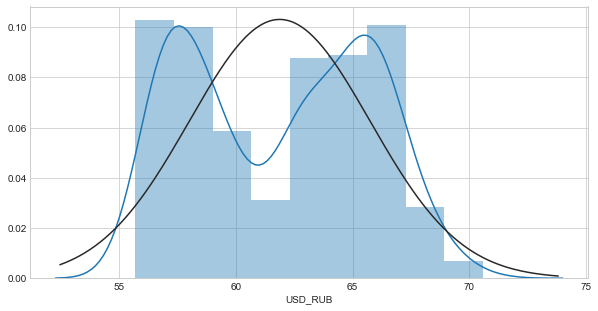

In [7]:
fig = plt.figure(figsize=(10,5))
sns.distplot(main_df['USD_RUB'], fit=norm);

Our target USD_RUB is not normally distributed thus making prediction modeling harder. Let's explore correlations between our target and features. 

In [8]:
corr_df= pd.DataFrame(abs(main_df.corr().USD_RUB).sort_values(ascending=False))
corr_df.rename(columns={'USD_RUB': 'corr_original'}, inplace=True)
corr_df

,corr_original
USD_RUB,1.000000
Treas_4M,0.865236
MOEXBC,0.695359
USD_Repo,0.621219
RGBITR_YIELD,0.570114
Brent,0.473830
Emerging_Markets,0.335388
EUR_USD,0.300332
Russia_ETF,0.125458
percent_change,0.064846


As we can see correlation with bonds indexes, stock indexes, repo rates and oil prices are the strongest.

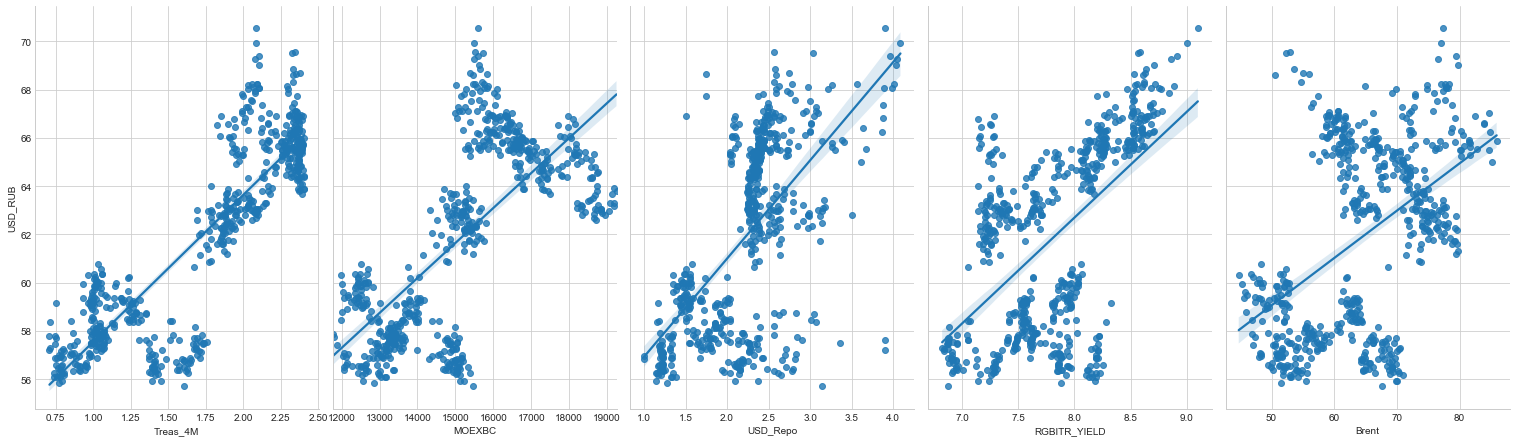

In [9]:
sns.pairplot(main_df, x_vars=['Treas_4M','MOEXBC','USD_Repo','RGBITR_YIELD','Brent'], y_vars='USD_RUB', size=6, aspect=0.7, kind='reg')

In [10]:
main_df.drop(['VOL_USD','percent_change','Emerging_Markets','EUR_USD'], 1,inplace=True)
main_df.head(1)

,Date,Brent,MOEXBC,RGBITR_YIELD,Russia_ETF,Treas_4M,USD_RUB,USD_Repo
0,2019-08-28,60.5,18106.96,7.14,21.870001,1.94,66.8,2.08


## Train/test split

In [11]:
test_df=main_df.drop('Date', 1)[:80] # the latest 80 trading days
train_df = main_df.drop('Date', 1)[80:]

## Feature-wise normalisation

In [12]:
train_targets = train_df.USD_RUB.values
train_data=train_df.drop("USD_RUB", 1).values

test_targets = test_df.USD_RUB.values
test_data=test_df.drop("USD_RUB", 1).values

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [13]:
EPOCHS =150 # how many passes through our data
BATCH_SIZE =5  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
opt='rmsprop' # set up an optimizer

NAME = f"{BATCH_SIZE}-{opt}--{test_df.drop('USD_RUB', 1).columns.tolist()}--{int(time.time())}" 

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
filepath = "regression-{epoch:02d}-{val_mean_absolute_error:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='max'))

tf.logging.set_verbosity(tf.logging.ERROR) # disable warnings

## Building and training our DNN

In [14]:
model = Sequential()
model.add(Dense(128, activation='relu',input_shape=(train_data.shape[1],)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(1))

model.compile(optimizer=opt, loss='mse', metrics=['mae'])

history = model.fit(
    train_data, train_targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(test_data, test_targets),
    callbacks=[tensorboard, checkpoint],
   )

Our validation metric to monitor during training is mae (Mean Absolute Error). It is simply the absolute value of the difference between the predictions and the targets.

## TensorBoard charts of the different features combinations tested  

![alt text](111.jpg)

And the best result which is the lowest mean absolute error belongs to (Brent, MOEXBC, RGBITR_YIELD, Russia_ETF, Treas_4M, USD_Repo) set of features. 

## Let's examine our features and get rid of outliers 

In [16]:
main_df=pd.read_csv('ML_DF_Regression.csv', nrows= 600)
main_df.reset_index(drop=True,inplace=True)
main_df.head(1)

,Date,Brent,EUR_USD,Emerging_Markets,MOEXBC,RGBITR_YIELD,Russia_ETF,Treas_4M,USD_RUB,USD_Repo,VOL_USD,percent_change
0,2019-08-28,60.5,1.10745,39.439999,18106.96,7.14,21.870001,1.94,66.8,2.08,1.834422e+11,0.613774


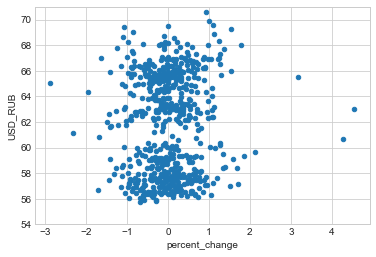

In [17]:
var = 'percent_change'
data = pd.concat([main_df['USD_RUB'], main_df[var]], axis=1)
data.plot.scatter(x=var, y='USD_RUB', ylim=(54,71));

In [18]:
main_df.drop(main_df.loc[(main_df.percent_change > 3) + (main_df.percent_change <-2)].index, axis=0, inplace=True)

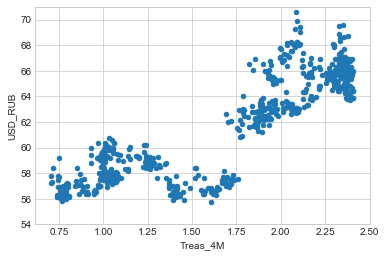

In [19]:
var = 'Treas_4M'
data = pd.concat([main_df['USD_RUB'], main_df[var]], axis=1)
data.plot.scatter(x=var, y='USD_RUB', ylim=(54,71));

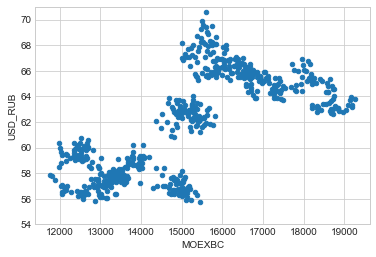

In [20]:
var = 'MOEXBC'
data = pd.concat([main_df['USD_RUB'], main_df[var]], axis=1)
data.plot.scatter(x=var, y='USD_RUB', ylim=(54,71));

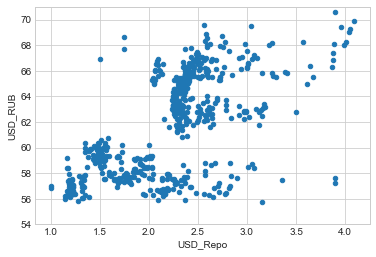

In [21]:
var = 'USD_Repo'
data = pd.concat([main_df['USD_RUB'], main_df[var]], axis=1)
data.plot.scatter(x=var, y='USD_RUB', ylim=(54,71));

In [22]:
main_df.drop(main_df.loc[((main_df.USD_RUB > 66) & (main_df.USD_Repo <2)) + ((main_df.USD_RUB < 58) & (main_df.USD_Repo >3))].index, axis=0, inplace=True)

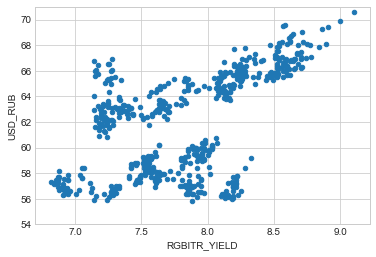

In [23]:
var = 'RGBITR_YIELD'
data = pd.concat([main_df['USD_RUB'], main_df[var]], axis=1)
data.plot.scatter(x=var, y='USD_RUB', ylim=(54,71));

In [24]:
main_df.drop(main_df.loc[(main_df.RGBITR_YIELD > 8.9)].index, axis=0, inplace=True)

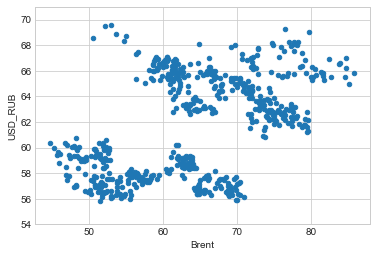

In [25]:
var = 'Brent'
data = pd.concat([main_df['USD_RUB'], main_df[var]], axis=1)
data.plot.scatter(x=var, y='USD_RUB', ylim=(54,71));

In [26]:
main_df['USD_RUB'].describe()

count    585.000000
mean      61.828073
std        3.831352
min       55.847500
25%       57.900000
50%       62.502500
75%       65.437500
max       69.560000
Name: USD_RUB, dtype: float64

In [27]:
corr_new = abs(main_df.corr().USD_RUB).sort_values(ascending=False)
corr_df['corr_new']=corr_new
corr_df

,corr_original,corr_new
USD_RUB,1.000000,1.000000
Treas_4M,0.865236,0.869337
MOEXBC,0.695359,0.703650
USD_Repo,0.621219,0.659734
RGBITR_YIELD,0.570114,0.551114
Brent,0.473830,0.480552
Emerging_Markets,0.335388,0.319814
EUR_USD,0.300332,0.298211
Russia_ETF,0.125458,0.153380
percent_change,0.064846,0.066026


In [28]:
main_df.set_index('Date',inplace=True)
main_df.to_csv('main_df_cleared.csv') # Save cleaned dataset just in case 

## Feature Engineering

In [29]:
main_df=pd.read_csv('main_df_cleared.csv')
main_df.head(1)

,Date,Brent,EUR_USD,Emerging_Markets,MOEXBC,RGBITR_YIELD,Russia_ETF,Treas_4M,USD_RUB,USD_Repo,VOL_USD,percent_change
0,2019-08-28,60.5,1.10745,39.439999,18106.96,7.14,21.870001,1.94,66.8,2.08,1.834422e+11,0.613774


In [30]:
main_df['MOEXBC_RusETF_Ratio']=main_df.MOEXBC/main_df.Russia_ETF 
main_df['Emerg_RusETF_Ratio']=main_df.Emerging_Markets/main_df.Russia_ETF
main_df['RGBITR_Treas_dif']=main_df.RGBITR_YIELD-main_df.Treas_4M
main_df.head(1)

,Date,Brent,EUR_USD,Emerging_Markets,MOEXBC,RGBITR_YIELD,Russia_ETF,Treas_4M,USD_RUB,USD_Repo,VOL_USD,percent_change,MOEXBC_RusETF_Ratio,Emerg_RusETF_Ratio,RGBITR_Treas_dif
0,2019-08-28,60.5,1.10745,39.439999,18106.96,7.14,21.870001,1.94,66.8,2.08,1.834422e+11,0.613774,827.935954,1.803383,5.2


In [31]:
abs(main_df.corr().USD_RUB).sort_values(ascending=False)

USD_RUB                1.000000
MOEXBC_RusETF_Ratio    0.955370
Treas_4M               0.869337
MOEXBC                 0.703650
USD_Repo               0.659734
RGBITR_YIELD           0.551114
Brent                  0.480552
Emerg_RusETF_Ratio     0.448094
RGBITR_Treas_dif       0.330005
Emerging_Markets       0.319814
EUR_USD                0.298211
Russia_ETF             0.153380
percent_change         0.066026
VOL_USD                0.029323
Name: USD_RUB, dtype: float64

In [32]:
main_df.drop(['VOL_USD','percent_change','Russia_ETF','EUR_USD','Emerging_Markets','Emerg_RusETF_Ratio','MOEXBC','RGBITR_YIELD','Treas_4M','USD_Repo'], 1,inplace=True)
main_df.head(1)

,Date,Brent,USD_RUB,MOEXBC_RusETF_Ratio,RGBITR_Treas_dif
0,2019-08-28,60.5,66.8,827.935954,5.2


## Train/test split

In [33]:
test_df=main_df.drop('Date', 1)[:80] # the latest 80 trading days
train_df = main_df.drop('Date', 1)[80:]

## Feature-wise normalisation

In [34]:
train_targets = train_df.USD_RUB.values
train_data=train_df.drop("USD_RUB", 1).values

test_targets = test_df.USD_RUB.values
test_data=test_df.drop("USD_RUB", 1).values

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [35]:
NAME = f"{BATCH_SIZE}-{opt}--{test_df.drop('USD_RUB', 1).columns.tolist()}--{int(time.time())}" 
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
filepath = "regression-{epoch:02d}-{val_mean_absolute_error:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='max'))

## Training DNN on cleaned dataset

In [36]:
model = Sequential()
model.add(Dense(128, activation='relu',input_shape=(train_data.shape[1],)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(1))

model.compile(optimizer=opt, loss='mse', metrics=['mae'])

history = model.fit(
    train_data, train_targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(test_data, test_targets),
    callbacks=[tensorboard, checkpoint],
   )

![alt text](222.png)

And this time the best result is (Brent, MOEXBC_RusETF_Ratio, RGBITR_Treas_dif) set of features.So Feature Engineering and data cleaning have reduced error and were helpful to improve our estimates.

## Getting and normalizing features to predict on

In [37]:
predict_df=main_df
predict_df.sort_index(ascending=False,inplace=True)
predict_df.head(2)

,Date,Brent,USD_RUB,MOEXBC_RusETF_Ratio,RGBITR_Treas_dif
584,2017-03-14,51.56,59.16,727.973063,7.577
583,2017-03-15,51.97,58.39,703.163880,7.565


In [38]:
predict_data=predict_df.drop(["USD_RUB",'Date'], 1).values
predict_data-= mean
predict_data /= std

## Some basic quantitative analysis of the results.

In [40]:
model = tf.keras.models.load_model("regression-144-0.546.model")# Load the most accurate model
prediction =  model.predict(predict_data,batch_size=1) # Predicting on all dataset
predict_df['prediction']=prediction
predict_df['deviation']=predict_df.USD_RUB-predict_df.prediction 
predict_df.head(2)

,Date,Brent,USD_RUB,MOEXBC_RusETF_Ratio,RGBITR_Treas_dif,prediction,deviation
584,2017-03-14,51.56,59.16,727.973063,7.577,58.052269,1.107731
583,2017-03-15,51.97,58.39,703.163880,7.565,55.870049,2.519951


In [41]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                x=predict_df.Date,
                y=predict_df.USD_RUB,
                name="USD/RUB real value",
                line_color='red',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=predict_df.Date,
                y=predict_df.prediction,
                name="USD/RUB 'fair'estimate",
                line_color='green',
                opacity=0.8))

fig.update_layout(
    title_text="USD/RUB values",
    autosize=False,
    width=990,
    height=550,
    margin=dict(l=20,r=0,b=30,t=30,pad=4),
    paper_bgcolor="LightSteelBlue")

fig.show()

![alt text](m_plotly_1.png)

In [42]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                x=predict_df.Date,
                y=predict_df.deviation,
                line_color='blue',
                opacity=0.8))

fig.update_layout(
    title_text="Deviation - difference between real and 'fair' values",
    autosize=False,
    width=990,
    height=550,
    margin=dict(l=20,r=24,b=30,t=30,pad=4),
    paper_bgcolor="LightSteelBlue")

fig.show()

![alt text](m_plotly_2.png)

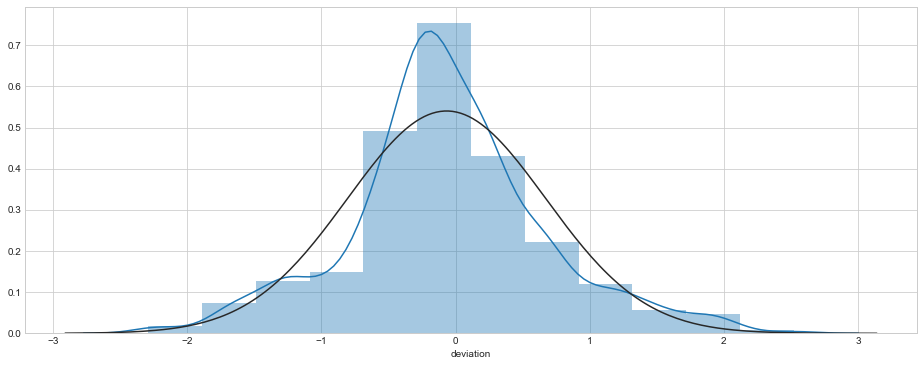

In [43]:
fig = plt.figure(figsize=(16,6))
sns.distplot(predict_df.deviation, bins=12, fit=norm);

Unlike USD/RUB, prediction error has quite normal (Gaussian) distribution thus Empirical Rule can be applied.  

![alt text](Empirical_Rule.png)

The normal distribution is commonly associated with the 68-95-99.7 rule which you can see in the image above. 68% of the data is within 1 standard deviation (σ) of the mean (μ), 95% of the data is within 2 standard deviations (σ) of the mean (μ), and 99.7% of the data is within 3 standard deviations (σ) of the mean (μ).

In [44]:
USD_mean = round(predict_df.USD_RUB.mean(axis=0),2)
USD_std =round(predict_df.USD_RUB.std(axis=0),2)

mean_abs_error = round(float(abs(predict_df.deviation).mean(axis=0)),2)
mean_error = round(float(predict_df.deviation.mean(axis=0)),2)
std_deviation =  round(float(predict_df.deviation.std(axis=0)),2)
Relative_Mispricing=predict_df.deviation/std_deviation
predict_df['Upper_limit']=mean_error + 2*std_deviation
predict_df['Lower_limit']=mean_error - 2*std_deviation
predict_df['mean_error']=mean_error

print("USD mean value =", USD_mean) # calculated for the all cleaned dataset 
print("USD standard deviation =", USD_std) # calculated for the all cleaned dataset
print("Mean Error =",mean_error) # Mean Error of our prediction calculated for the all cleaned dataset
print("Mean Absolute Error =",mean_abs_error) # Mean Absolute Error of our prediction calculated for the all cleaned dataset 
print("Standard deviation of the error =", std_deviation) # standard deviation of  prediction error calculated for the all cleaned dataset

USD mean value = 61.83
USD standard deviation = 3.83
Mean Error = -0.07
Mean Absolute Error = 0.55
Standard deviation of the error = 0.74


In [45]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                x=predict_df.Date,
                y=predict_df.deviation,
                name="deviation",
                line_color='blue',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=predict_df.Date,
                y=predict_df.mean_error+2*std_deviation,
                name="μ+2σ)",
                line_color='red',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=predict_df.Date,
                y=predict_df.mean_error+std_deviation,
                name="μ+σ)",
                line_color='coral',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=predict_df.Date,
                y=predict_df.mean_error-std_deviation,
                name="μ-σ)",
                line_color='olive',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=predict_df.Date,
                y=predict_df.mean_error-2*std_deviation,
                name="μ-2σ)",
                line_color='green',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=predict_df.Date,
                y=predict_df.mean_error,
                name="μ)",
                line_color='yellow',
                opacity=0.8))

fig.update_layout(
    title_text="Deviation values and μ ± σ limits",
    autosize=False,
    width=990,
    height=550,
    margin=dict(l=20,r=20,b=30,t=30,pad=4),
    paper_bgcolor="LightSteelBlue")            

fig.show()

![alt text](m_plotly_3.png)

## Wrapping up
Quantitative analysis and statistical approach of assets pricing can be useful and give good results for the purposes of 'fair' baised on underlying fundamentals pricing as well as detection and evaluation of anomalys in market pricing. And even though fundamentals isn't always price movement's main driving force good understanding of them can give some adge.